In [1]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

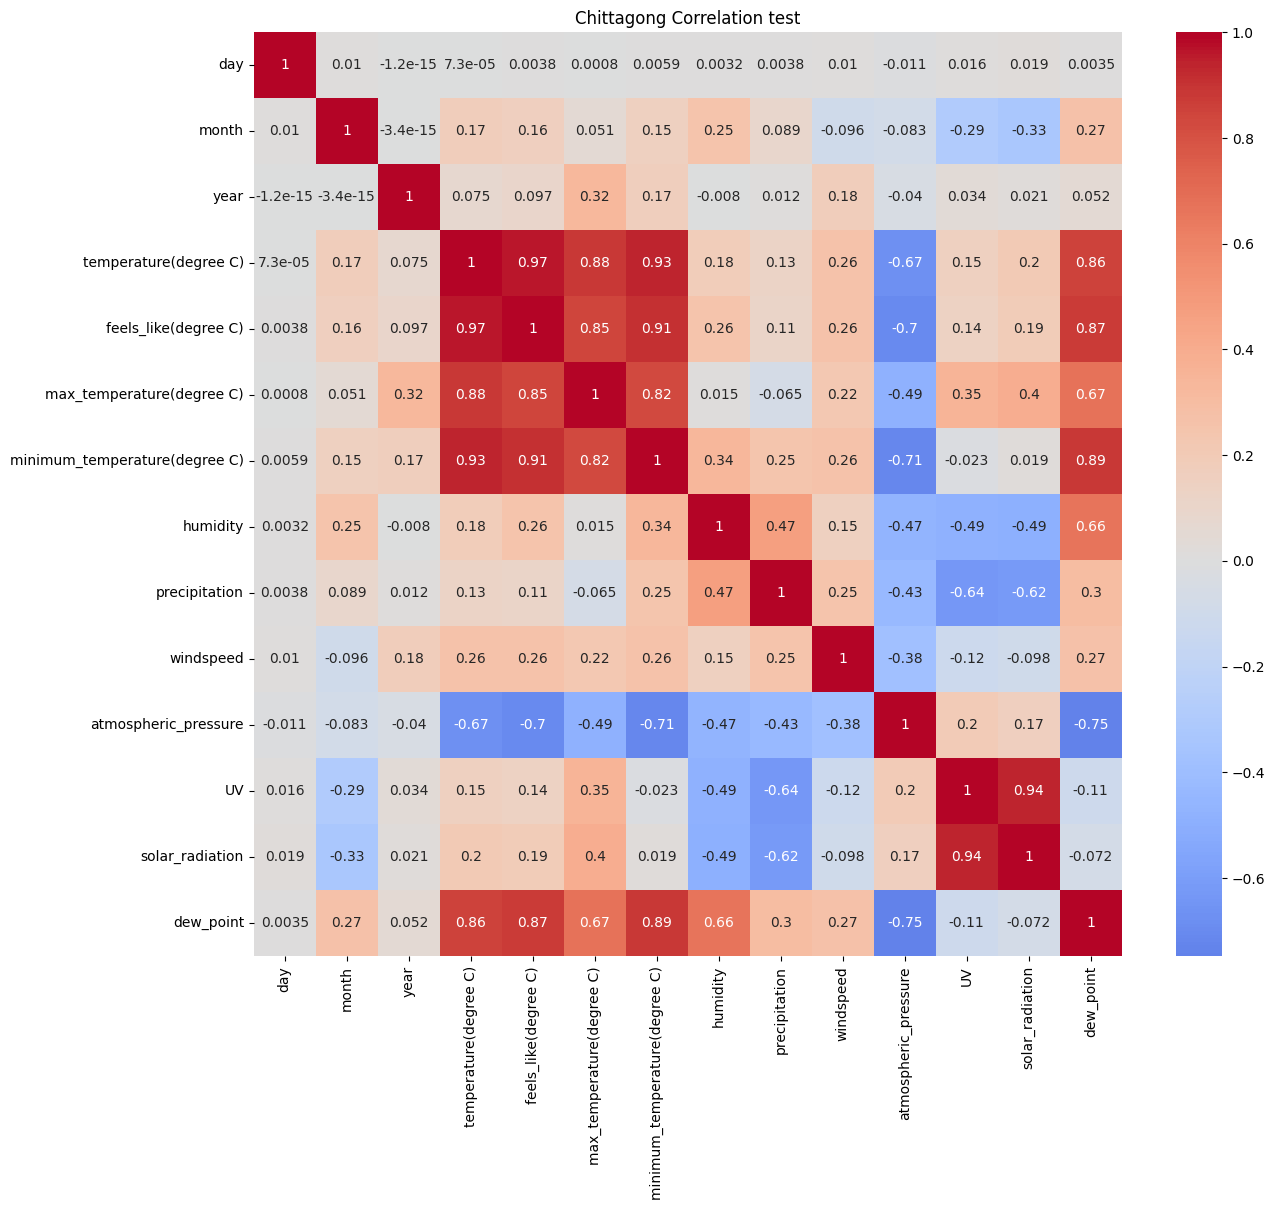

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_chittagong.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Chittagong Correlation test')
plt.show()

In [3]:
df_chittagong.head()

,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Temperature


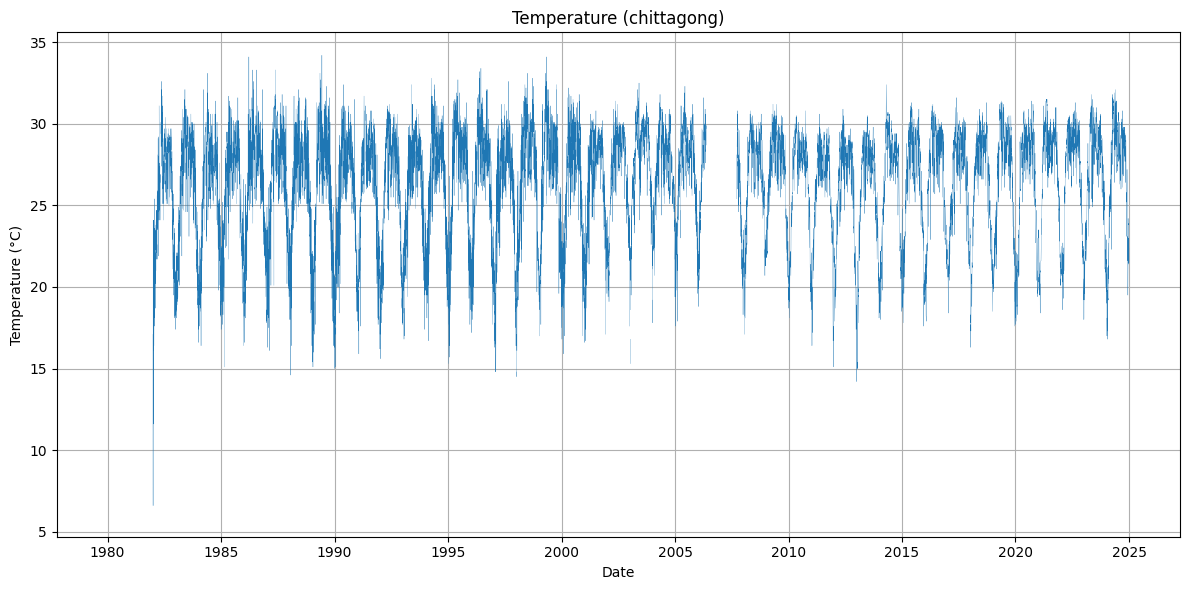

In [4]:
import matplotlib.pyplot as plt

if 'date' not in df_chittagong.columns:
    df_chittagong['date'] = pd.to_datetime(df_chittagong[['year', 'month', 'day']])



min_date = df_chittagong['date'].min()
max_date = df_chittagong['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_chittagong['date'], df_chittagong['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature (chittagong)')
plt.grid(True)
plt.tight_layout()
plt.show()

## RF with lagging rolling


- time series part

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



- feature engeering part

In [21]:

# FEATURES = [
#     'dew_roll_7',
#     'dew_point',
#     'dew_lag_1',
#     'dew_lag_2',
#     'dew_lag_3',
#     'atm_roll_7',
#     'day_of_year_sin_3',
#     'day_of_year_cos_1',
#     'atmospheric_pressure', # ~ 1.7
#     'atm_lag_2',  # 1.9
#     'atm_lag_1', # 86.13/88.0 *-1.86
#     'day_of_year_sin_1',  # 86.34/87.93 *-1.5 [ better]
#     # 'atm_lag_3', 
#     # 'day_of_year_sin_2', # -1.7
# #    'day_of_year_cos_2', # 86.19/87.88 *-1.69
# # #    'day_of_year_cos_3' # 86.30/87.91 *-1.6
# ]


FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols 
# 86.40/87.93 ~ -1.53

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''

Random Forest Feature Importances (from last fold):
                 Feature  Importance
15            dew_roll_7    0.194442
1              dew_point    0.167315
9              dew_lag_1    0.160662
11             dew_lag_2    0.118672
13             dew_lag_3    0.075158
14            atm_roll_7    0.054073
6      day_of_year_sin_3    0.041480
3      day_of_year_cos_1    0.029418
0   atmospheric_pressure    0.028322
10             atm_lag_2    0.024513
8              atm_lag_1    0.024098
2      day_of_year_sin_1    0.019313
12             atm_lag_3    0.019240
4      day_of_year_sin_2    0.018426
5      day_of_year_cos_2    0.016615
7      day_of_year_cos_3    0.008253

'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for temperature:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for temperature:
MSE: 0.8143
RMSE: 0.9024
R² Score: 0.9282
Average RMSE from CV: 0.8539
Average R² from CV: 0.9330
Avarage MSE: 0.7334663070367915
Individual Fold RMSEs: [np.float64(0.9263484144093739), np.float64(0.8255456947866668), np.float64(0.8381515064904055), np.float64(0.7542442087973216), np.float64(0.9253659718122135)]

 R2 ~ -0.4718

Random Forest Feature Importances (from last fold):
                 Feature  Importance
10            feel_lag_1    0.215844
19           feel_roll_7    0.172628
13            feel_lag_2    0.134891
16            feel_lag_3    0.117480
18            dew_roll_7    0.071004
1              dew_point    0.066621
9              dew_lag_1    0.057335
12             dew_lag_2    0.041579
15             dew_lag_3    0.026075
17            atm_roll_7    0.021558
6      day_of_year_sin_3    0.014601
11             atm_lag_2    0.011374
3      day_of_year_cos_1    0.008776
14             atm_lag_3    0.007637
2      day_of_year_sin_

## RF -LSTM HYBRID

In [13]:

FEATURES = [
    'dew_roll_7',
    'dew_point',
    'dew_lag_1',
    'dew_lag_2',
    'dew_lag_3',
    'atm_roll_7',
    'day_of_year_sin_3',
    'day_of_year_cos_1',
    'atmospheric_pressure', # ~ 1.7
    'atm_lag_2',  # 1.9
    'atm_lag_1',
    'day_of_year_sin_1',  # 0.8634 - 0.8739 - 1.5851
    #'atm_lag_3', # 0.863 - 0.879 ` -1.5`
    #'day_of_year_sin_2', #0.86/0.87 ~ -1.7
   # 'day_of_year_cos_2',
   # 'day_of_year_cos_3'
]


#FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols 
#0.8640  0.8793 ~ 1.53

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Windowed UV R2: 0.8635
Windowed UV MSE: 1.5538
Windowed UV RMSE: 1.2465


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = [
    'dew_roll_7',
    'dew_point',
    'dew_lag_1',
    'dew_lag_2',
    'dew_lag_3',
    'atm_roll_7',
    'day_of_year_sin_3',
    'day_of_year_cos_1',
    'atmospheric_pressure', # ~ 1.7
    'atm_lag_2',  # 1.9
    'atm_lag_1',
    'day_of_year_sin_1',  # 0.8634 - 0.8739 - 1.5851
    #'atm_lag_3', # 0.863 - 0.879 ` -1.5`
    #'day_of_year_sin_2', #0.86/0.87 ~ -1.7
   # 'day_of_year_cos_2',
   # 'day_of_year_cos_3'
]
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
--- HYBRID MODEL PERFORMANCE ---
Final temperature R2: 0.8683
Final temperature MSE: 1.5002
Final temperature RMSE: 1.5002


In [16]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

TEMP = 'temperature(degree C)'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = [
       'dew_roll_7',
    'dew_point',
    'dew_lag_1',
    'dew_lag_2',
    'dew_lag_3',
    'atm_roll_7',
    'day_of_year_sin_3',
    'day_of_year_cos_1',
    'atmospheric_pressure', # ~ 1.7
    'atm_lag_2',  # 1.9
    'atm_lag_1',
    'day_of_year_sin_1',  # 0.8634 - 0.8739 - 1.5851
    #'atm_lag_3', # 0.863 - 0.879 ` -1.5`
    #'day_of_year_sin_2', #0.86/0.87 ~ -1.7
   # 'day_of_year_cos_2',
   # 'day_of_year_cos_3'
    ]

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 1 R2: 0.8624
Fold 1 MSE: 1.5016
Fold 1 RMSE: 1.2254
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 2 R2: 0.9003
Fold 2 MSE: 1.1298
Fold 2 RMSE: 1.0629
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Fold 3 R2: 0.8891
Fold 3 MSE: 1.3679
Fold 3 RMSE: 1.1696
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 4 R2: 0.9026
Fold 4 MSE: 1.0228
Fold 4 RMSE: 1.0114
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 5 R2: 0.8417
Fold 5 MSE: 1.6044
Fold 5 RMSE: 1.2667

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.8792 (+/- 0.0236)
Mean mse: 1.3253 (+/- 0.2193)
Mean rmse: 1.1472 (+/- 0.0964)


## XGBoost

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [18]:
FEATURES = [
'dew_roll_7',
'day_of_year_sin_3',
'dew_point',
'day_of_year_cos_1',
'day_of_year_sin_1',
'day_of_year_sin_2',
'dew_lag_1',
'atm_roll_7',
'day_of_year_cos_3',
'day_of_year_cos_2',
'dew_lag_2',
'atm_lag_2',
'atm_lag_1',
#'dew_lag_3', # 0.8598/0.8665 ~0.66
#'atmospheric_pressure',
#'atm_lag_3' #0.854/0.867 ~1.2
# #0.85/0.86 ~1.1

 ]






#FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 0.84/0.86 ~1.7

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''


XGBoost Feature Importances:
                 Feature  Importance
15            dew_roll_7    0.682703
6      day_of_year_sin_3    0.138269
1              dew_point    0.048434
3      day_of_year_cos_1    0.037955
2      day_of_year_sin_1    0.014656
4      day_of_year_sin_2    0.012544
9              dew_lag_1    0.011720
14            atm_roll_7    0.009275
7      day_of_year_cos_3    0.007737
5      day_of_year_cos_2    0.007175
11             dew_lag_2    0.005761
10             atm_lag_2    0.005529
8              atm_lag_1    0.005146
13             dew_lag_3    0.004750
0   atmospheric_pressure    0.004188
12             atm_lag_3    0.004157
'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for temperature:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for temperature:
Mean Squared Error: 1.5908
RMSE: 1.2613
R² Score: 0.8598


Average RMSE from CV: 1.2037
Average R² from CV: 0.8665
Avarage MSE: 1.7666214353716552
Individual Fold RMSEs: [np.float64(1.3096921942723505), np.float64(1.1198336429122357), np.float64(1.1948352684590118), np.float64(1.0651454681809867), np.float64(1.3291431207254)]

 R2 ~ -0.6674

XGBoost Feature Importances:
              Feature  Importance
0          dew_roll_7    0.552669
1   day_of_year_sin_3    0.135041
2           dew_point    0.089679
3   day_of_year_cos_1    0.069982
4   day_of_year_sin_1    0.030067
5   day_of_year_sin_2    0.023993
6           dew_lag_1    0.020413
7          atm_roll_7    0.016249
9   day_of_year_cos_2    0.015881
8   day_of_year_cos_3    0.014271
12          atm_lag_1    0.011078
11          atm_lag_2    0.010728
10          dew_lag_2    0.009948


## LightGBM

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [21]:
FEATURES = [
'dew_point',
'temp_roll_7',
'day_of_year_sin_3',
'atm_roll_7',
'day_of_year_sin_2',
'day_of_year_cos_1',
'dew_lag_3',
'atmospheric_pressure',
'dew_lag_1',
'day_of_year_cos_3',
'day_of_year_sin_1',
'atm_lag_1',
'day_of_year_cos_2',
'atm_lag_2', # 0.8865 / 0.8935 ~0.6968
#'atm_lag_3',
#'dew_lag_2'
# 0.88/0.89 ~0.69

 ]






FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 0.88/0.89 ~ -.69

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [22]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                 Feature  Importance
1              dew_point         636
14           temp_roll_7         584
6      day_of_year_sin_3         351
15            atm_roll_7         350
4      day_of_year_sin_2         320
3      day_of_year_cos_1         295
13             dew_lag_3         274
0   atmospheric_pressure         262
9              dew_lag_1         261
7      day_of_year_cos_3         226
2      day_of_year_sin_1         224
8              atm_lag_1         220
5      day_of_year_cos_2         211
10             atm_lag_2         206
12             atm_lag_3         190
11             dew_lag_2         180

'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for temp:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)


LightGBM Results for temp:
Mean Squared Error: 1.2879
RMSE: 1.1348
R² Score: 0.8865


Average RMSE from CV: 1.0734
Average R² from CV: 0.8935
Avarage MSE: 1.2982985299138396
Individual Fold RMSEs: [np.float64(1.2585135578201876), np.float64(0.9981505950945758), np.float64(1.0773221130380026), np.float64(0.8936036875775002), np.float64(1.1394290368047673)]

 R2 ~ -0.6968

LightGBM Feature Importances:
                 Feature  Importance
1              dew_point         636
14           temp_roll_7         584
6      day_of_year_sin_3         351
15            atm_roll_7         350
4      day_of_year_sin_2         320
3      day_of_year_cos_1         295
13             dew_lag_3         274
0   atmospheric_pressure         262
9              dew_lag_1         261
7      day_of_year_cos_3         226
2      day_of_year_sin_1         224
8              atm_lag_1         220
5      day_of_year_cos_2         211
10             atm_lag_2         206
12             atm_lag_3         190
11 

## CATBOOST

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [24]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'temp_lag_1',


#     ]

FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [25]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   43.960021
8                      temp_lag_1   10.761866
6               day_of_year_sin_3    7.732805
14                    temp_roll_7    7.551957
3               day_of_year_cos_1    4.006128
2               day_of_year_sin_1    3.907999
10                     temp_lag_2    3.767410
4               day_of_year_sin_2    3.340417
9                       atm_lag_1    2.673542
12                     temp_lag_3    2.317698
5               day_of_year_cos_2    2.278235
1            atmospheric_pressure    1.917982
15                     atm_roll_7    1.841164
7               day_of_year_cos_3    1.651114
13                      atm_lag_3    1.179426
11                      atm_lag_2    1.112237
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for UV :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for UV :
Mean Squared Error: 1.5750
RMSE: 1.2550
R² Score: 0.8612


Average RMSE from CV: 1.1433
Average R² from CV: 0.8795
Avarage MSE: 1.3168733903121799
Individual Fold RMSEs: [np.float64(1.224801470360946), np.float64(1.048491994962045), np.float64(1.1420589211258747), np.float64(1.0226057710692678), np.float64(1.2786210165313672)]

 R2 ~ -1.8279

CatBoost Feature Importances:
                 Feature  Importance
15            dew_roll_7   23.145773
1              dew_point   16.632023
6      day_of_year_sin_3   13.652640
3      day_of_year_cos_1    6.954257
9              dew_lag_1    6.946793
11             dew_lag_2    5.085097
4      day_of_year_sin_2    4.899340
2      day_of_year_sin_1    3.735182
5      day_of_year_cos_2    3.550658
0   atmospheric_pressure    3.103215
7      day_of_year_cos_3    2.768330
13             dew_lag_3    2.766952
14            atm_roll_7    2.638898
8              atm_lag_1    1.599207
10             atm_lag_2    1.384231
12    

## GRU

In [27]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [27]:
FEATURES = [
    
    ]

''''

'''

FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 90.47/91.73 *-1.26


X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [28]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for temperature :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

Epoch 1/100


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.4034 - val_loss: 0.1407
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1410 - val_loss: 0.1256
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1313 - val_loss: 0.1247
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1238 - val_loss: 0.1212
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1195 - val_loss: 0.1196
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1187 - val_loss: 0.1171
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1135 - val_loss: 0.1148
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1156 - val_loss: 0.1177
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1112 - val_loss: 0.1139
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1118 - val_loss: 0.1124
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1097 - val_loss: 0.1131
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1055 - val_l

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


Average RMSE from CV: 1.1387
Average R² from CV: 0.8807
Average MSE: 1.3027
Individual Fold RMSEs: [np.float64(1.173628535024351), np.float64(1.0403859332825278), np.float64(1.1363895974979505), np.float64(1.079158699737364), np.float64(1.2639712641266363)]

 R2 ~ -2.2341


In [29]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)


GRU Permutation Feature Importances:
                 Feature  Importance
1              dew_point    4.532285
15            dew_roll_7    0.903323
5      day_of_year_cos_2    0.796785
4      day_of_year_sin_2    0.570762
6      day_of_year_sin_3    0.556196
9              dew_lag_1    0.350172
7      day_of_year_cos_3    0.223191
2      day_of_year_sin_1    0.124106
14            atm_roll_7    0.098638
8              atm_lag_1    0.078371
13             dew_lag_3    0.037050
3      day_of_year_cos_1    0.032197
0   atmospheric_pressure    0.003832
10             atm_lag_2    0.000000
11             dew_lag_2    0.000000
12             atm_lag_3    0.000000


## lSTM

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [31]:


FEATURES = [ 'atmospheric_pressure','dew_point'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 91.24/92.25 *1.01
##
'''



'''


X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [32]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for temp :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

LSTM Results for temp :
Mean Squared Error: 1.4714
RMSE: 1.2130
R² Score: 0.8703


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Average RMSE from LSTM CV: 1.1423
Average R² from LSTM CV: 0.8800
Average MSE: 1.3129
Individual Fold RMSEs: [np.float64(1.1586750391111713), np.float64(1.0657398382086571), np.float64(1.1741510670754096), np.float64(1.0274745433110792), np.float64(1.2852641622073344)]

 R2 ~ -0.9684

LSTM Permutation Feature Importances:
                 Feature  Importance
1              dew_point    4.303774
15            dew_roll_7    1.025216
5      day_of_year_cos_2    0.659975
4      day_of_year_sin_2    0.523478
9              dew_lag_1    0.393425
6      day_of_year_sin_3    0.371692
7      day_of_year_cos_3    0.357389
14            atm_roll_7    0.258932
13             dew_lag_3    0.210544
2      day_of_year_sin_1    0.132333
3      day_of_year_cos_1    0.109136
0   atmospheric_pressure    0.057221
10             atm_lag_2    0.053602
11             dew_lag_2    0.033333
12             atm_lag_3    0.025236
8              atm_lag_1    0.020409


## ANN

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for temperature :
Mean Squared Error: 1.5877
RMSE: 1.2600
R² Score: 0.8601


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Average RMSE from ANN CV: 1.1735
Average R² from ANN CV: 0.8731
Average MSE: 1.3874
Individual Fold RMSEs: [np.float64(1.2631660463688346), np.float64(1.103719777463289), np.float64(1.161409792215893), np.float64(1.0307511771439184), np.float64(1.3083316763562347)]

 R2 ~ -1.2975

ANN Permutation Feature Importances:
                 Feature  Importance
1              dew_point    5.360027
14            atm_roll_7    0.768229
15            dew_roll_7    0.739378
4      day_of_year_sin_2    0.681427
6      day_of_year_sin_3    0.671331
9              dew_lag_1    0.525278
5      day_of_year_cos_2    0.513340
0   atmospheric_pressure    0.486095
2      day_of_year_sin_1    0.360198
3      day_of_year_cos_1    0.320795
12             atm_lag_3    0.087752
13             dew_lag_3    0.044473
7      day_of_year_cos_3    0.017458
10             atm_lag_2    0.003376
11             dew_lag_2    0.000000
8              atm_lag_1    0.000000


## CNN-LSTM model hybrid

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','dew_point','feels_like(degree C), [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'feel_lag_{lag}'] = df['feels_like(degree C)'].shift(lag)

    lag_cols.extend([f'atm_lag_{lag}', f'dew_lag_{lag}', f'feel_lag_{lag}'])

# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['feel_roll_7'] = df['feels_like(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7','feel_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['temperature(degree C)'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['temperature(degree C)'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Base Results: R2: 0.9074, MSE: 1.0549, RMSE: 1.0271


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5-Fold CV Average: R2: 0.8539, MSE: 1.6068, RMSE: 1.2601



## model chart for temperature

In [38]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF       MSE    MSE CV  \
5              GRU  0.858403  0.880743 -0.022341  1.606898  1.302679   
4         CatBoost  0.861215  0.879494 -0.018279  1.574980  1.316873   
0    Random Forest  0.863446  0.879298 -0.015851  1.549662  1.320782   
7              ANN  0.860093  0.873068 -0.012975  1.587719  1.387368   
1   RF-LSTM hybrid  0.868281  0.879233 -0.010952  1.500163  1.325295   
6             LSTM  0.870340  0.880024 -0.009684  1.471428  1.312914   
3         LightGBM  0.886514  0.893482 -0.006968  1.287880  1.298299   
2          XGBoost  0.859823  0.866497 -0.006674  1.590785  1.766621   
8  CNN-LSTM hybrid  0.907383  0.853862  0.053521  1.054903  1.606780   

       RMSE   RMSE CV  
5  1.267635  1.138707  
4  1.254982  1.143316  
0  1.244854  1.145397  
7  1.260047  1.173476  
1  1.224811  1.147173  
6  1.213024  1.142261  
3  1.134848  1.073404  
2  1.261263  1.203730  
8  1.027085  1.260054  


## best model for temperature

In [39]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

The Best Logical Model is: CNN-LSTM hybrid
--- Reason: Balanced score across R^2 (0.9074) and Stability (DIFF: 0.0535)


<h1>Humidity Prediction </h1>

## RF 

In [31]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

In [32]:
df_chittagong.head()

,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7' ,'atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [34]:
FEATURES = [
   
    ]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
 

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''

Random Forest Feature Importances (from last fold):
                 Feature  Importance
0              dew_point    0.186775
3          precipitation    0.108665
10             dew_lag_1    0.088150
1        solar_radiation    0.080636
13             ppt_lag_1    0.053163
25            ppt_roll_7    0.052779
22            dew_roll_7    0.051517
14             dew_lag_2    0.037632
11           solar_lag_1    0.033232
18             dew_lag_3    0.029392
23          solar_roll_7    0.028234
4      day_of_year_sin_1    0.023292
17             ppt_lag_2    0.022505
24            atm_roll_7    0.020220
6      day_of_year_sin_2    0.019927
5      day_of_year_cos_1    0.018931
15           solar_lag_2    0.016846
16             atm_lag_2    0.016830
20             atm_lag_3    0.016316
7      day_of_year_cos_2    0.016253
19           solar_lag_3    0.014812
2   atmospheric_pressure    0.014456
12             atm_lag_1    0.014212
8      day_of_year_sin_3    0.012930
9      day_of_year_cos_3    0.012264
21             ppt_lag_3    0.010033


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for humidity:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for humidity:
MSE: 20.9791
RMSE: 4.5803
R² Score: 0.7754
Average RMSE from CV: 4.2416
Average R² from CV: 0.7447
Avarage MSE: 18.039810483557332
Individual Fold RMSEs: [np.float64(4.2458889403543525), np.float64(4.088269140090962), np.float64(4.343100077299967), np.float64(3.9442915648352392), np.float64(4.586674256176228)]

 R2 ~ 3.0649

Random Forest Feature Importances (from last fold):
                 Feature  Importance
0              dew_point    0.186775
3          precipitation    0.108665
10             dew_lag_1    0.088150
1        solar_radiation    0.080636
13             ppt_lag_1    0.053163
25            ppt_roll_7    0.052779
22            dew_roll_7    0.051517
14             dew_lag_2    0.037632
11           solar_lag_1    0.033232
18             dew_lag_3    0.029392
23          solar_roll_7    0.028234
4      day_of_year_sin_1    0.023292
17             ppt_lag_2    0.022505
24            atm_roll_7    0.020220
6      day_of_year_sin_2    0

## RF LSTM Hybrid 

In [45]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [46]:
FEATURES = [
   



    ]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Windowed UV R2: 0.7787
Windowed UV MSE: 20.7977
Windowed UV RMSE: 4.5605


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

################################################################
# lstm_feature_cols = [
# 
# 
# 
# 
# ]
lstm_feature_cols = FEATURES

X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final humidity R2: {rf_lstm_r2:.4f}")
print(f"Final humidity MSE: {rf_lstm_mse:.4f}")
print(f"Final humidity RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
--- HYBRID MODEL PERFORMANCE ---
Final humidity R2: 0.7688
Final humidity MSE: 21.7163
Final humidity RMSE: 21.7163


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

HUM = 'humidity'
X_full = df[FEATURES]
y_full = df[HUM]

fold = 1

lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    ################################################################
    
    # --- STEP 2: Preprocessing for LSTM ---
    # lstm_feature_cols = [
    #     'dew_point', 
    #     'solar_radiation', 
    #     'precipitation', 
    #     'dew_lag_1', 
    #     'ppt_roll_7', 
    #     'ppt_lag_1', 
    #     'dew_roll_7', # 77.89/76.19 *1.69
    #     'dew_lag_2', # 77.15/75.79 *1.35
    #     'UV', # 77.94/76.95 *0.99
    #     'solar_lag_1',  # 78.25/77.45 *0.80 [better]
    #     # 'solar_roll_7', # 78.93/77.67 *1.25
    #     # 'day_of_year_sin_1', # 79.27/77.84 *1.43
    #     # 'dew_lag_3', 
    #     # 'ppt_lag_2', 
    #     # 'UV_roll_7', # 78.35/76.86 *1.48
    # ]

    lstm_feature_cols = FEATURES

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 1 R2: 0.6748
Fold 1 MSE: 19.0097
Fold 1 RMSE: 4.3600
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Fold 2 R2: 0.7272
Fold 2 MSE: 16.6511
Fold 2 RMSE: 4.0806
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Fold 3 R2: 0.7592
Fold 3 MSE: 19.2618
Fold 3 RMSE: 4.3888
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Fold 4 R2: 0.7763
Fold 4 MSE: 15.6445
Fold 4 RMSE: 3.9553
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 5 R2: 0.7551
Fold 5 MSE: 21.5681
Fold 5 RMSE: 4.6441

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.7385 (+/- 0.0355)
Mean mse: 18.4270 (+/- 2.0880)
Mean rmse: 4.2858 (+/- 0.2433)


## XGBoost

In [56]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [57]:
# FEATURES = [
    



# ]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

X = df[FEATURES]
y = df['humidity']
'''






'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [58]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for humidity:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for humidity:
Mean Squared Error: 16.0911
RMSE: 4.0114
R² Score: 0.8277


Average RMSE from CV: 3.8361
Average R² from CV: 0.7905
Avarage MSE: 16.40766493338629
Individual Fold RMSEs: [np.float64(3.9510226966627133), np.float64(3.596021899569285), np.float64(3.8741931733600805), np.float64(3.7084851089476363), np.float64(4.050637595908364)]

 R2 ~ 3.7179

XGBoost Feature Importances:
                 Feature  Importance
0              dew_point    0.292455
3          precipitation    0.185627
1        solar_radiation    0.162707
6      day_of_year_sin_2    0.045695
4      day_of_year_sin_1    0.034329
23          solar_roll_7    0.026442
5      day_of_year_cos_1    0.025140
13             ppt_lag_1    0.022033
22            dew_roll_7    0.019523
25            ppt_roll_7    0.018634
8      day_of_year_sin_3    0.018043
11           solar_lag_1    0.017558
24            atm_roll_7    0.016098
14             dew_lag_2    0.013814
10             dew_lag_1    0.011170
16  

## LightGBM

In [61]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [62]:
FEATURES = [
    
]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [63]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


'''





'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for humidity:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)




LightGBM Results for humidity:
Mean Squared Error: 16.4331
RMSE: 4.0538
R² Score: 0.8240


Average RMSE from CV: 3.8335
Average R² from CV: 0.7917
Avarage MSE: 16.79560367628357
Individual Fold RMSEs: [np.float64(3.8514539666662233), np.float64(3.5959079827100933), np.float64(3.980882668880387), np.float64(3.6410355451085996), np.float64(4.098243974714483)]

 R2 ~ 3.2386

LightGBM Feature Importances:
                 Feature  Importance
0              dew_point         937
1        solar_radiation         358
22            dew_roll_7         307
10             dew_lag_1         257
23          solar_roll_7         214
24            atm_roll_7         208
6      day_of_year_sin_2         203
4      day_of_year_sin_1         188
3          precipitation         161
5      day_of_year_cos_1         153
14             dew_lag_2         148
18             dew_lag_3         146
19           solar_lag_3         142
11           solar_lag_1         140
20             atm_lag_3         140
16

## CATBoost

In [64]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [65]:
FEATURES = [
    



]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [66]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
 

'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for temperature :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for temperature :
Mean Squared Error: 15.1939
RMSE: 3.8979
R² Score: 0.8373


Average RMSE from CV: 3.7140
Average R² from CV: 0.8041
Avarage MSE: 13.813011360790492
Individual Fold RMSEs: [np.float64(3.685668563253886), np.float64(3.609004153272825), np.float64(3.7417462884911914), np.float64(3.5672236101585657), np.float64(3.9661370998925)]

 R2 ~ 3.3163

CatBoost Feature Importances:
                 Feature  Importance
0              dew_point   41.963296
1        solar_radiation   13.047026
3          precipitation    7.303795
6      day_of_year_sin_2    3.885458
23          solar_roll_7    2.947477
4      day_of_year_sin_1    2.933296
11           solar_lag_1    2.848829
8      day_of_year_sin_3    2.489566
10             dew_lag_1    2.360772
5      day_of_year_cos_1    2.289970
22            dew_roll_7    1.795762
7      day_of_year_cos_2    1.706933
14             dew_lag_2    1.562059
18             dew_lag_3    1.462342
24            atm_roll_7    1.427700


## GRU

In [67]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [68]:
FEATURES = [
    
    



]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

'''

GRU Permutation Feature Importances:


'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [69]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for humidity :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

Epoch 1/100


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4588 - val_loss: 0.3999
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2966 - val_loss: 0.3125
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2386 - val_loss: 0.2515
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1981 - val_loss: 0.2125
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1864 - val_loss: 0.2144
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1744 - val_loss: 0.2145
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1627 - val_loss: 0.1996
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1607 - val_loss: 0.2002
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1580 - val_loss: 0.2103
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1517 - val_loss: 0.1967
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1554 - val_loss: 0.1916
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1503 - val_l

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Average RMSE from CV: 3.6975
Average R² from CV: 0.8050
Average MSE: 13.7477
Individual Fold RMSEs: [np.float64(3.957106298814833), np.float64(3.3267172113170607), np.float64(3.6899429086504583), np.float64(3.4646434544519766), np.float64(4.048879742569256)]

 R2 ~ 3.0061


In [70]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)


GRU Permutation Feature Importances:
                 Feature  Importance
0              dew_point  222.352755
22            dew_roll_7   13.973144
5      day_of_year_cos_1   13.125956
3          precipitation    8.255561
23          solar_roll_7    5.964264
1        solar_radiation    4.917838
10             dew_lag_1    3.648261
8      day_of_year_sin_3    3.315410
4      day_of_year_sin_1    1.793609
7      day_of_year_cos_2    1.698761
19           solar_lag_3    1.475373
6      day_of_year_sin_2    1.316249
13             ppt_lag_1    1.180024
11           solar_lag_1    1.141389
24            atm_roll_7    1.023494
14             dew_lag_2    0.906871
21             ppt_lag_3    0.420407
9      day_of_year_cos_3    0.415105
15           solar_lag_2    0.397908
17             ppt_lag_2    0.273559
18             dew_lag_3    0.235225
16             atm_lag_2    0.198218
20             atm_lag_3    0.152417
12             atm_lag_1    0.141562
25            ppt_roll_7    0.110512


## LSTM

In [71]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [72]:
FEATURES = [




]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 84.03/81.07 *2.95 

'''
LSTM Permutation Feature Importances:
   


'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [73]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for humidity :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

LSTM Results for humidity :
Mean Squared Error: 15.6314
RMSE: 3.9537
R² Score: 0.8326


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Average RMSE from LSTM CV: 3.6746
Average R² from LSTM CV: 0.8073
Average MSE: 13.5555
Individual Fold RMSEs: [np.float64(3.8810519109632304), np.float64(3.2904892416157003), np.float64(3.588633660970123), np.float64(3.6813011791005668), np.float64(3.931554191498676)]

 R2 ~ 2.5279

LSTM Permutation Feature Importances:
                 Feature  Importance
0              dew_point  212.439220
5      day_of_year_cos_1   10.501879
3          precipitation    7.580276
22            dew_roll_7    7.174838
1        solar_radiation    5.227539
23          solar_roll_7    4.004837
4      day_of_year_sin_1    3.622351
10             dew_lag_1    3.285830
25            ppt_roll_7    2.326712
8      day_of_year_sin_3    2.192802
7      day_of_year_cos_2    2.157215
11           solar_lag_1    1.685694
6      day_of_year_sin_2    1.194349
14             dew_lag_2    0.951047
13             ppt_lag_1    0.808055
20             atm_lag_3    0.699137
19     

## ANN

In [74]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [75]:
FEATURES = [
    
   



]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

'''
ANN Permutation Feature Importances:
  




'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for humidity :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for humidity :
Mean Squared Error: 16.9471
RMSE: 4.1167
R² Score: 0.8185


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Average RMSE from ANN CV: 3.7144
Average R² from ANN CV: 0.8039
Average MSE: 13.8388
Individual Fold RMSEs: [np.float64(3.7827681896253593), np.float64(3.505782321851308), np.float64(3.5985514557160627), np.float64(3.6009429609810923), np.float64(4.083847422701244)]

 R2 ~ 1.4615

ANN Permutation Feature Importances:
                 Feature  Importance
0              dew_point  229.504162
5      day_of_year_cos_1   36.717483
22            dew_roll_7   12.251314
1        solar_radiation    9.682214
10             dew_lag_1    5.242371
23          solar_roll_7    5.056248
4      day_of_year_sin_1    4.972698
24            atm_roll_7    4.569285
3          precipitation    3.890773
14             dew_lag_2    3.636632
8      day_of_year_sin_3    3.173550
7      day_of_year_cos_2    2.618083
6      day_of_year_sin_2    2.334684
11           solar_lag_1    1.909358
19           solar_lag_3    1.067303
2   atmospheric_pressure    0.861895
18         

## CNN-LSTM model hybrid

In [77]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [78]:
FEATURES = [


]

FEATURES = [ 'dew_point','solar_radiation','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


'''


'''


X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['humidity'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['humidity'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Base Results: R2: 0.4154, MSE: 54.9453, RMSE: 7.4125


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
5-Fold CV Average: R2: 0.4766, MSE: 38.7268, RMSE: 6.1701



## model chart humidty

In [81]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF        MSE     MSE CV  \
8  CNN-LSTM hybrid  0.415353  0.476593 -0.061240  54.945283  38.726795   
7              ANN  0.818540  0.803926  0.014615  16.947096  13.838803   
6             LSTM  0.832628  0.807348  0.025279  15.631422  13.555454   
5              GRU  0.835103  0.805042  0.030061  15.400217  13.747720   
1   RF-LSTM hybrid  0.768843  0.738519  0.030324  21.716298  18.427037   
0    Random Forest  0.775367  0.744718  0.030649  20.979117  18.039810   
3         LightGBM  0.824044  0.791657  0.032386  16.433107  16.795604   
4         CatBoost  0.837312  0.804149  0.033163  15.193946  13.813011   
2          XGBoost  0.827705  0.790526  0.037179  16.091121  16.407665   

       RMSE   RMSE CV  
8  7.412509  6.170136  
7  4.116685  3.714378  
6  3.953659  3.674606  
5  3.924311  3.697458  
1  4.660075  4.285774  
0  4.580297  4.241645  
3  4.053777  3.833505  
4  3.897941  3.713956  
2  4.011374  3.836072  


## Best model for humidity

In [82]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

The Best Logical Model is: GRU
--- Reason: Balanced score across R^2 (0.8351) and Stability (DIFF: 0.0301)


# DEW POINT

## temperature

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                          Feature  Importance
2   minimum_temperature(degree C)    0.216909
20                  mintem_roll_7    0.146150
11                   mintem_lag_1    0.131497
14                   mintem_lag_2    0.122413
17                   mintem_lag_3    0.073617
18                     atm_roll_7    0.056844
12                      atm_lag_2    0.039081
0            atmospheric_pressure    0.035956
4               day_of_year_cos_1    0.025367
15                      atm_lag_3    0.025037
9                       atm_lag_1    0.024415
1                        humidity    0.024317
7               day_of_year_sin_3    0.019913
3               day_of_year_sin_1    0.010451
19                     dew_roll_7    0.009862
10                      hum_lag_1    0.009594
5               day_of_year_sin_2    0.008322
6               day_of_year_cos_2    0.007584
13                      hum_lag_2    0.005335
16                      hum_lag_3    0.004013
8               day_of_year_cos_3    0.003323


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for dewpoint:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)



## RF-LSTM hybrid

In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-1.12 [best]
#     # 'day_of_year_sin_2', #
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = FEATURES
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

DEW = 'dew_point'
X_full = df[FEATURES]
y_full = df[DEW]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = FEATURES

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



## XGBoost

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''

XGBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    0.686006
14                    temp_roll_7    0.137628
6               day_of_year_sin_3    0.045227
3               day_of_year_cos_1    0.018808
4               day_of_year_sin_2    0.016560
2               day_of_year_sin_1    0.016441
15                     atm_roll_7    0.011273
7               day_of_year_cos_3    0.010194
8                      temp_lag_1    0.009055
1            atmospheric_pressure    0.008524
5               day_of_year_cos_2    0.007986
9                       atm_lag_1    0.007748
11                      atm_lag_2    0.006355
12                     temp_lag_3    0.006175
10                     temp_lag_2    0.006093
13                      atm_lag_3    0.005929


'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for dewpoint:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)


## LightGBM

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)         852
14                    temp_roll_7         431
8                      temp_lag_1         384
15                     atm_roll_7         384
6               day_of_year_sin_3         324
4               day_of_year_sin_2         309
9                       atm_lag_1         302
1            atmospheric_pressure         291
7               day_of_year_cos_3         277
11                      atm_lag_2         261
3               day_of_year_cos_1         260
2               day_of_year_sin_1         234
5               day_of_year_cos_2         234
12                     temp_lag_3         192
13                      atm_lag_3         172


'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for dewpont:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)

## CatBoost

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   43.960021
8                      temp_lag_1   10.761866
6               day_of_year_sin_3    7.732805
14                    temp_roll_7    7.551957
3               day_of_year_cos_1    4.006128
2               day_of_year_sin_1    3.907999
10                     temp_lag_2    3.767410
4               day_of_year_sin_2    3.340417
9                       atm_lag_1    2.673542
12                     temp_lag_3    2.317698
5               day_of_year_cos_2    2.278235
1            atmospheric_pressure    1.917982
15                     atm_roll_7    1.841164
7               day_of_year_cos_3    1.651114
13                      atm_lag_3    1.179426
11                      atm_lag_2    1.112237
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for dewpoint :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    


## GRU

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for dewpoint :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

In [ ]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)

## LSTM

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for dewpoint :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

## ANN

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for dew :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

## CNN-LSTM

In [ ]:
import pandas as pd
import numpy as np
df_chittagong = pd.read_csv('../../1980-2024-dataset/Chittagong_historical_weather_1980_2024.csv')
df_chittagong = df_chittagong.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_chittagong.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'mintem_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    # df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'atm_lag_{lag}', f'hum_lag_{lag}', f'mintem_lag_{lag}'])


# 7-day Rolling Average
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['mintem_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['atm_roll_7', 'dew_roll_7', 'mintem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'mintem_roll_7',
#     'mintem_lag_1',
#     'mintem_lag_2',
#     'mintem_lag_3',
#     'atm_roll_7',
#     'atm_lag_2',
#     'atmospheric_pressure',
#     'day_of_year_cos_1',
#     'atm_lag_3',
#     'atm_lag_1',
#     'humidity', # 93.44/94.73 *-1.28
#     'day_of_year_sin_3', # 93.38/94.71 *-1.32
#     'day_of_year_sin_1', # 93.20/94.49 *-1.29
#     'dew_roll_7',
#     'hum_lag_1', # 93.75/94.87 *-0.096 [best]
#     # 'day_of_year_sin_2', 
# ]

FEATURES = [ 'atmospheric_pressure','humidity', 'minimum_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# *0.08

X = df[FEATURES]
y = df['dew_point']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['dew_point'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['dew_point'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

## Model performance dew point

In [ ]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

## best model dewpont

In [ ]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'MSE': 0.3,
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['MSE'].rank(ascending=True) * weights['MSE'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE']  +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

# Solar radition 

## rf

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                      Feature  Importance
0                          UV    0.312220
2                    humidity    0.127007
1               precipitation    0.111885
22                  uv_roll_7    0.084029
10                   uv_lag_1    0.056731
4           day_of_year_sin_1    0.056554
3   max_temperature(degree C)    0.034918
12                  hum_lag_1    0.029826
11                  ppt_lag_1    0.028973
14                   uv_lag_2    0.018893
23                 ppt_roll_7    0.017312
5           day_of_year_cos_1    0.014907
24                 hum_roll_7    0.013159
18                   uv_lag_3    0.011445
13                  max_lag_1    0.009295
25              maxtem_roll_7    0.008934
6           day_of_year_sin_2    0.007871
9           day_of_year_cos_3    0.007707
7           day_of_year_cos_2    0.007491
16                  hum_lag_2    0.007037
15                  ppt_lag_2    0.006987
8           day_of_year_sin_3    0.005784
20                  hum_lag_3    0.005731
17                  max_lag_2    0.005501
19                  ppt_lag_3    0.005314
21                  max_lag_3    0.004492


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for solar rad:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)



## rf-lstm

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



## xgboost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## lightgbm

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## catboost

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## gru

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## lstm

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## ann

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## CNN-lstm

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'[collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'uv_lag_{lag}'] = df['UV'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'max_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    # df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    
    
    lag_cols.extend([f'uv_lag_{lag}', f'ppt_lag_{lag}', f'hum_lag_{lag}', f'max_lag_{lag}'])


# 7-day Rolling Average
df['uv_roll_7'] = df['UV'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['maxtem_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['uv_roll_7', 'ppt_roll_7', 'hum_roll_7', 'maxtem_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [ ]:
FEATURES = [

]

FEATURES = [ 'UV', 'precipitation' ,'humidity' , 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)


X = df[FEATURES]
y = df['solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## model performance chart solar 

## best mdoel solar rad